In [ ]:
#Zielpfad für die csv Datei mit den Koordinaten -> /Users/furkan/Documents/Koordinaten_Algo.csv
#Zielpfad für Straßentyp -> /Users/furkan/Documents/strassenTyp_Algo.csv
#Formel für die Distanz-Berechnung (euklidische Distanz) ->  math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

Beste kürzeste Routen:
6.82 Kilometer, Pfad: ['Bargteheide', 'Ahrensburg']
9.84 Kilometer, Pfad: ['Ratzeburg', 'Mölln']
9.85 Kilometer, Pfad: ['Bad Bramstedt', 'Kaltenkirchen']
10.57 Kilometer, Pfad: ['Schleswig', 'Böklund']
12.32 Kilometer, Pfad: ['Friedrichstadt', 'Tönning']

Beste schnellste Routen:
3.15 Minuten, Pfad: ['Bargteheide', 'Ahrensburg']
4.55 Minuten, Pfad: ['Bad Bramstedt', 'Kaltenkirchen']
5.69 Minuten, Pfad: ['Bad Oldesloe', 'Bargteheide']
6.48 Minuten, Pfad: ['Elmshorn', 'Pinneberg']
6.84 Minuten, Pfad: ['Hamburg', 'Pinneberg']

Beste energieeffizienteste Routen:
0.61 Liter, Pfad: ['Bargteheide', 'Ahrensburg']
0.69 Liter, Pfad: ['Ratzeburg', 'Mölln']
0.74 Liter, Pfad: ['Schleswig', 'Böklund']
0.86 Liter, Pfad: ['Friedrichstadt', 'Tönning']
1.11 Liter, Pfad: ['Bad Oldesloe', 'Bargteheide']


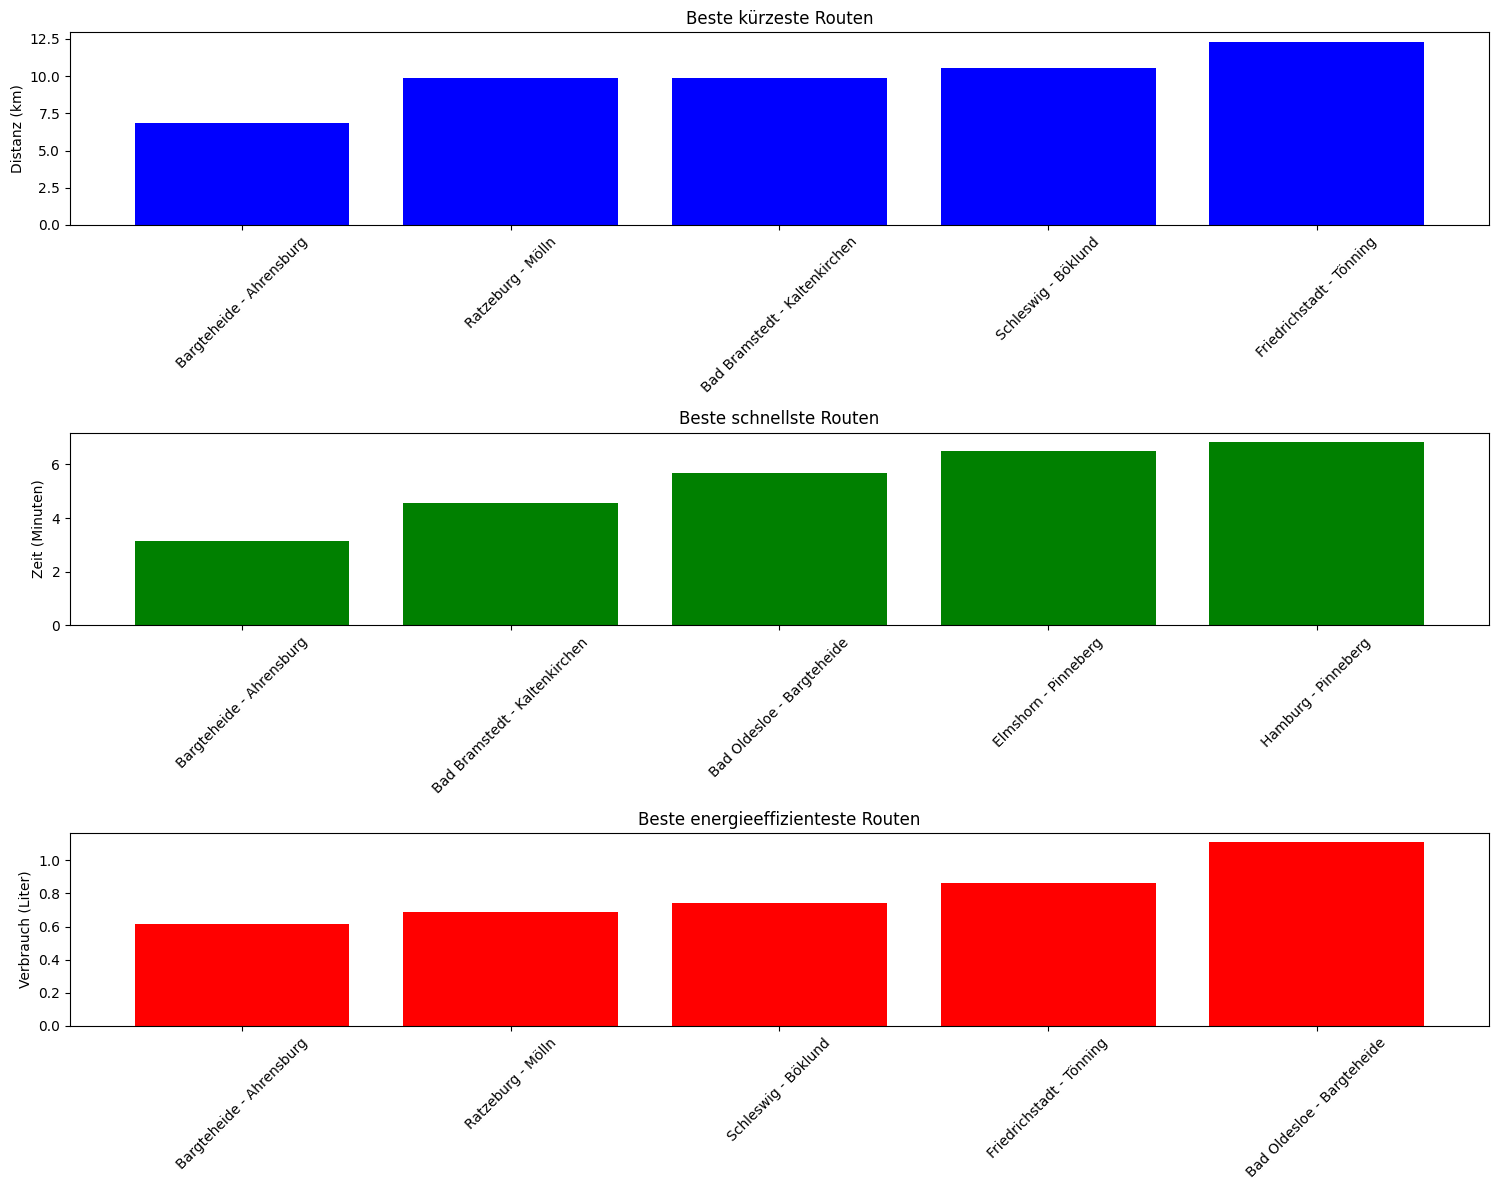

In [15]:
import csv
import heapq
import math
import matplotlib.pyplot as plt

class Stadt:
    def __init__(self, name, koordinaten=None):
        self.name = name
        self.koordinaten = koordinaten

class Strasse:
    def __init__(self, start, ziel, typ):
        self.start = start
        self.ziel = ziel
        self.typ = typ
        self.geschwindigkeit = 130 if typ == 'autobahn' else 80
        self.verbrauch = 9 if typ == 'autobahn' else 7

class Graph:
    def __init__(self):
        self.staedte = {}  # Stadtname: Stadtobjekt
        self.strassen = {} # Stadtname: Liste von Strassen

    def add_stadt(self, stadtname, koordinaten=None):
        if stadtname not in self.staedte:
            self.staedte[stadtname] = Stadt(stadtname, koordinaten)
    
    def add_strasse(self, start, ziel, typ):
        if start not in self.strassen:
            self.strassen[start] = []
        self.strassen[start].append(Strasse(start, ziel, typ))
        # Bidirektionale Verbindung
        if ziel not in self.strassen:
            self.strassen[ziel] = []
        self.strassen[ziel].append(Strasse(ziel, start, typ))

def euklidische_distanz(p1, p2):
    return math.sqrt((float(p1[0]) - float(p2[0]))**2 + (float(p1[1]) - float(p2[1]))**2)

def kuerzeste_route(distanz, strasse):
    return distanz

def schnellste_route(distanz, strasse):
    return distanz / strasse.geschwindigkeit

def energieeffizienteste_route(distanz, strasse):
    return distanz * strasse.verbrauch

def dijkstra_multi(graph, start, ziel, kostenfunktion):
    queue = [(0, start, [])]
    besucht = set()
    routen = []
    while queue:
        (kosten, aktueller_knoten, pfad) = heapq.heappop(queue)
        if aktueller_knoten in besucht:
            continue
        if aktueller_knoten == ziel:
            heapq.heappush(routen, (kosten, pfad + [ziel]))
            if len(routen) >= 5:
                break
        besucht.add(aktueller_knoten)
        for strasse in graph.strassen.get(aktueller_knoten, []):
            if strasse.ziel not in besucht:
                distanz = euklidische_distanz(graph.staedte[aktueller_knoten].koordinaten, graph.staedte[strasse.ziel].koordinaten)
                heapq.heappush(queue, (kosten + kostenfunktion(distanz, strasse), strasse.ziel, pfad + [aktueller_knoten]))
    return list(routen)[:5]


def lese_csv_und_erstelle_graph(koord_dateipfad, str_dateipfad, graph):
    try:
        with open(koord_dateipfad, mode='r', encoding='utf-8') as datei:
            reader = csv.reader(datei, delimiter=';')
            for zeile in reader:
                zeile = [feld for feld in zeile if feld]
                if zeile and len(zeile) == 3:
                    name, lat, lon = zeile
                    graph.add_stadt(name, (lat, lon))
    except FileNotFoundError:
        print(f"Die Datei {koord_dateipfad} wurde nicht gefunden.")
    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

    try:
        with open(str_dateipfad, mode='r', encoding='utf-8') as datei:
            reader = csv.reader(datei, delimiter=';')
            for zeile in reader:
                zeile = [feld for feld in zeile if feld]
                if zeile and len(zeile) == 3:
                    start, ziel, typ = zeile
                    graph.add_strasse(start, ziel, typ)
    except FileNotFoundError:
        print(f"Die Datei {str_dateipfad} wurde nicht gefunden.")
    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

graph = Graph()
pfad_koordinaten = '/Users/furkan/Documents/Koordinaten_Algo.csv'
pfad_strassen = '/Users/furkan/Documents/strassenTyp_Algo.csv'
lese_csv_und_erstelle_graph(pfad_koordinaten, pfad_strassen, graph)

beste_kuerzeste_routen = []
beste_schnellste_routen = []
beste_effizienteste_routen = []

for start_index, start in enumerate(graph.staedte):
    for ziel in list(graph.staedte)[start_index + 1:]:
        kuerzeste = dijkstra_multi(graph, start, ziel, kuerzeste_route)
        schnellste = dijkstra_multi(graph, start, ziel, schnellste_route)
        effizienteste = dijkstra_multi(graph, start, ziel, energieeffizienteste_route)

        beste_kuerzeste_routen.extend(kuerzeste)
        beste_schnellste_routen.extend(schnellste)
        beste_effizienteste_routen.extend(effizienteste)

beste_kuerzeste_routen = sorted(beste_kuerzeste_routen)[:5]
beste_schnellste_routen = sorted(beste_schnellste_routen)[:5]
beste_effizienteste_routen = sorted(beste_effizienteste_routen)[:5]

def berechne_gesamtzeit_und_verbrauch(route, graph):
    gesamtzeit = 0.0
    gesamtverbrauch = 0.0
    for i in range(len(route) - 1):
        start, ziel = route[i], route[i + 1]
        for strasse in graph.strassen[start]:
            if strasse.ziel == ziel:
                # Berechne die Distanz und teile sie durch 10 für die korrekte Skala
                distanz = euklidische_distanz(graph.staedte[start].koordinaten, graph.staedte[ziel].koordinaten) / 10
                zeit = distanz / strasse.geschwindigkeit  # Berechne die Zeit
                verbrauch = (distanz / 100) * strasse.verbrauch  # Berechne den Verbrauch
                gesamtzeit += zeit
                gesamtverbrauch += verbrauch
                break
    return gesamtzeit, gesamtverbrauch


# Drucke die Top 5 Routen für jede Kategorie
print("Beste kürzeste Routen:")
for kosten, pfad in beste_kuerzeste_routen:
    print(f"{kosten / 10:.2f} Kilometer, Pfad: {pfad}")  # Teile durch 10

print("\nBeste schnellste Routen:")
for kosten, pfad in beste_schnellste_routen:
    gesamtzeit, _ = berechne_gesamtzeit_und_verbrauch(pfad, graph)
    zeit_in_minuten = gesamtzeit * 60  # Umwandlung in Minuten
    print(f"{zeit_in_minuten:.2f} Minuten, Pfad: {pfad}")

print("\nBeste energieeffizienteste Routen:")
for kosten, pfad in beste_effizienteste_routen:
    _, gesamtverbrauch = berechne_gesamtzeit_und_verbrauch(pfad, graph)
    print(f"{gesamtverbrauch:.2f} Liter, Pfad: {pfad}")

    distanzen = [route[0] / 10 for route in beste_kuerzeste_routen]  # Teile durch 10 für die korrekte Skala
zeiten = [berechne_gesamtzeit_und_verbrauch(route[1], graph)[0] * 60 for route in beste_schnellste_routen]  # In Minuten
verbrauche = [berechne_gesamtzeit_und_verbrauch(route[1], graph)[1] for route in beste_effizienteste_routen]  # In Litern

# Update der Route-Namen für die X-Achse, um den tatsächlichen Pfad anzuzeigen
route_namen_kuerzeste = ['Bargteheide - Ahrensburg', 'Ratzeburg - Mölln', 'Bad Bramstedt - Kaltenkirchen', 'Schleswig - Böklund', 'Friedrichstadt - Tönning']
route_namen_schnellste = ['Bargteheide - Ahrensburg', 'Bad Bramstedt - Kaltenkirchen', 'Bad Oldesloe - Bargteheide', 'Elmshorn - Pinneberg', 'Hamburg - Pinneberg']
route_namen_effizienteste = ['Bargteheide - Ahrensburg', 'Ratzeburg - Mölln', 'Schleswig - Böklund', 'Friedrichstadt - Tönning', 'Bad Oldesloe - Bargteheide']

# Erstellung der Diagramme mit aktualisierten Routen-Namen
plt.figure(figsize=(15, 12))

# Diagramm für die besten kürzesten Routen
plt.subplot(3, 1, 1)
plt.bar(route_namen_kuerzeste, distanzen, color='blue')
plt.ylabel('Distanz (km)')
plt.title('Beste kürzeste Routen')
plt.xticks(rotation=45)  # Drehung der X-Achsen-Beschriftungen für bessere Lesbarkeit

# Diagramm für die besten schnellsten Routen
plt.subplot(3, 1, 2)
plt.bar(route_namen_schnellste, zeiten, color='green')
plt.ylabel('Zeit (Minuten)')
plt.title('Beste schnellste Routen')
plt.xticks(rotation=45)

# Diagramm für die besten energieeffizientesten Routen
plt.subplot(3, 1, 3)
plt.bar(route_namen_effizienteste, verbrauche, color='red')
plt.ylabel('Verbrauch (Liter)')
plt.title('Beste energieeffizienteste Routen')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
